In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from datasets import load_dataset

In [2]:
# from datasets import load_dataset

# snli = load_dataset("snli")
# print(snli)

# print("DONE!!!")

In [3]:
from datasets import load_dataset

multi_nli = load_dataset("multi_nli")
print(multi_nli)

print("DONE!!!")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})
DONE!!!


In [4]:
dataset_used = multi_nli

premise_train = dataset_used["train"]["premise"]
hypothesis_train = dataset_used["train"]["hypothesis"]
labels_train = dataset_used["train"]["label"]

premise_val = dataset_used["validation_matched"]["premise"]
hypothesis_val = dataset_used["validation_matched"]["hypothesis"]
labels_val = dataset_used["validation_matched"]["label"]

premise_test = dataset_used["validation_mismatched"]["premise"]
hypothesis_test = dataset_used["validation_mismatched"]["hypothesis"]
labels_test = dataset_used["validation_mismatched"]["label"]

print(len(premise_train), len(premise_val), len(premise_test))

labels_train = torch.tensor(labels_train)
labels_val = torch.tensor(labels_val)
labels_test = torch.tensor(labels_test)

print("DONE!!!!")

392702 9815 9832
DONE!!!!


In [5]:
# dataset_used = snli

# premise_train = dataset_used["train"]["premise"][:10000]
# hypothesis_train = dataset_used["train"]["hypothesis"][:10000]
# labels_train = dataset_used["train"]["label"][:10000]

# premise_val = dataset_used["validation"]["premise"][:1000]
# hypothesis_val = dataset_used["validation"]["hypothesis"][:1000]
# labels_val = dataset_used["validation"]["label"][:1000]

# premise_test = dataset_used["test"]["premise"][:1000]
# hypothesis_test = dataset_used["test"]["hypothesis"][:1000]
# labels_test = dataset_used["test"]["label"][:1000]

# print(len(premise_train), len(premise_val), len(premise_test))
# print("DONE!!!")

In [6]:
labels_val_np = labels_val.cpu().numpy()
unique_labels = set(labels_val_np.tolist())
print(unique_labels)

{0, 1, 2}


In [7]:
count_0 = (labels_train == 0).sum().item()
count_1 = (labels_train == 1).sum().item()
count_2 = (labels_train == 2).sum().item()

print("Label 0 count:", count_0)
print("Label 1 count:", count_1)
print("Label 2 count:", count_2)

Label 0 count: 130899
Label 1 count: 130900
Label 2 count: 130903


In [8]:
# Vocab...
from collections import Counter
from nltk.tokenize import word_tokenize
import time

start_time = time.time()
def build_vocab(texts_A, texts_B):
    vocab = Counter()
    for text in texts_A + texts_B:
        tokens = word_tokenize(text.lower())
        vocab.update(tokens)
        
    vocab_dict = {}
    vocab_dict["<UNK>"] = 0
    idx = 1 
#     for word in vocab:
    for word in sorted(vocab):
        vocab_dict[word] = idx
        idx += 1
    return vocab_dict

vocab = build_vocab(premise_train, hypothesis_train)
print("DONE!!!")
print("Time Taken :", time.time() - start_time)

DONE!!!
Time Taken : 166.07894086837769


In [9]:
# HyperParameters...
vocab_size = len(vocab) + 1 
embedding_dim = 100
hidden_dim = 30
output_dim = 3
max_len = 50
print(vocab_size)
print("DONE!!!")

85137
DONE!!!


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize

class NLIDataset(Dataset):
    def __init__(self, premise, hypothesis, label, vocab, max_len):
        self.premise = premise
        self.hypothesis = hypothesis
        self.label = label
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.premise)

    def __getitem__(self, idx):
        premise = self.premise[idx]
        hypothesis = self.hypothesis[idx]
        label = self.label[idx]
        
        if label == -1:
            return None

        # Clipping
        premise = [self.vocab.get(token, 0) for token in word_tokenize(premise.lower())][:self.max_len]
        hypothesis = [self.vocab.get(token, 0) for token in word_tokenize(hypothesis.lower())][:self.max_len]

        # Padding
        padded_tokens_premise = torch.tensor(premise + [0] * (self.max_len - len(premise)), dtype=torch.long)
        padded_tokens_hypothesis = torch.tensor(hypothesis + [0] * (self.max_len - len(hypothesis)), dtype=torch.long)

        # Move tensors to GPU
        padded_tokens_premise = padded_tokens_premise.to(device)
        padded_tokens_hypothesis = padded_tokens_hypothesis.to(device)
        label = label.to(device)

        return padded_tokens_premise, padded_tokens_hypothesis, label
print("DONE!!!")

DONE!!!


In [11]:
import torch.nn.init as init

class LSTMModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()
        
#         for name, param in self.named_parameters():
#             # Xavier initialization for lstm, fc and bais tersm
#             if 'weight' in name:
#                 if 'lstm' in name:
#                     init.xavier_uniform_(param)
#                 elif 'fc' in name:
#                     init.xavier_uniform_(param)
#             elif 'bias' in name:
#                 init.constant_(param, 0.0)

    def forward(self, premise, hypothesis):
#         print("Premise :", premise, premise.size())
#         print("Hypo :", hypothesis, hypothesis.size())
        premise_embedded = self.embedding(premise)
        hypothesis_embedded = self.embedding(hypothesis)

        _, (hidden_premise, _) = self.lstm(premise_embedded)
        _, (hidden_hypothesis, _) = self.lstm(hypothesis_embedded)

        hidden_premise = hidden_premise.squeeze(0)
        hidden_hypothesis = hidden_hypothesis.squeeze(0)
        
#         print("Sizes :", hidden_premise.size(), hidden_hypothesis.size(), hidden_premise[0].size(), hidden_premise[0])

        premise_out = self.fc1(hidden_premise)
        hypothesis_out = self.fc1(hidden_hypothesis)

        combined = torch.cat((premise_out, hypothesis_out), dim=1)
        
#         print("Combined :", combined.size())
        x = self.relu(combined)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
#         print("X :", x.size())
        
        return x

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2 * 2, output_dim)  # Double the hidden_dim for bidirectional LSTM and 2 for premise and hypothesis

    def forward(self, premise, hypothesis):
        premise_embedded = self.embedding(premise)
        hypothesis_embedded = self.embedding(hypothesis)

        _, (premise_hidden, _) = self.lstm(premise_embedded)
        _, (hypothesis_hidden, _) = self.lstm(hypothesis_embedded)

        # Concatenate the hidden states of both directions for both premise and hypothesis
        combined_hidden = torch.cat((premise_hidden[-2,:,:], premise_hidden[-1,:,:], hypothesis_hidden[-2,:,:], hypothesis_hidden[-1,:,:]), dim=1)

        # Apply fully connected layer
        output = self.fc(combined_hidden)

        return output

In [24]:
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = NLIDataset(premise_train, hypothesis_train, labels_train, vocab, max_len)
val_dataset = NLIDataset(premise_val, hypothesis_val, labels_val, vocab, max_len)
test_dataset = NLIDataset(premise_test, hypothesis_test, labels_test, vocab, max_len)
print(len(train_dataset))

train_dataset_filtered = [data for data in train_dataset if data is not None]
val_dataset_filtered = [data for data in val_dataset if data is not None]
test_dataset_filtered = [data for data in test_dataset if data is not None]
print(len(train_dataset_filtered))


train_loader = DataLoader(train_dataset_filtered, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset_filtered, batch_size=64, drop_last=True)
test_loader = DataLoader(test_dataset_filtered, batch_size=64, drop_last=True)

print("DONE!!!")

cuda
392702


KeyboardInterrupt: 

In [13]:
def calculate_accuracy(outputs, scores):
    _, predicted = torch.max(outputs, 1)
#     print(predicted[:10], scores[:10], sep = "\n")
    correct = (predicted == scores).sum().item()
    total = scores.size(0)
    accuracy = correct / total
    return accuracy

print("DONE!!!")

DONE!!!


In [14]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    total_accuracy = 0
    for premise, hypothesis, score in train_loader:
        premise, hypothesis, score = premise.to(device), hypothesis.to(device), score.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(premise, hypothesis)
        loss = criterion(outputs, score)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        accuracy = calculate_accuracy(outputs, score)
        total_accuracy += accuracy
        
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    return avg_loss, avg_accuracy


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for premise, hypothesis, score in val_loader:
            premise, hypothesis, score = premise.to(device), hypothesis.to(device), score.to(device)  # Move data to GPU
            outputs = model(premise, hypothesis)
            loss = criterion(outputs, score)
            running_loss += loss.item()
            
            accuracy = calculate_accuracy(outputs, score)
            total_accuracy += accuracy
            
    avg_loss = running_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    return avg_loss, avg_accuracy


def test(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        correct = 0
        total = 0
        for premise, hypothesis, score in test_loader:
            premise, hypothesis, score = premise.to(device), hypothesis.to(device), score.to(device)  # Move data to GPU
            outputs = model(premise, hypothesis)

            _, predicted = torch.max(outputs, 1)
            total += score.size(0)
            correct += (predicted == score).sum().item()
            
            predictions.extend(predicted.cpu())  # Move predictions back to CPU
            true_labels.extend(score.cpu())  # Move true labels back to CPU
        
    accuracy = correct / total
    return predictions, true_labels, accuracy

print("DONE!!!")

DONE!!!


In [15]:
# def print_model_parameters(model):
#     for name, param in model.named_parameters():
#         print(name, param.data)

# print("Model Parameters Before Training:")
# print_model_parameters(model)

In [27]:
num_epochs = 5
model.to(device)

for epoch in range(num_epochs):
    print("Epoch :", epoch + 1)
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print("Train Loss :", train_loss, "  Val Loss :", val_loss)
    print("Train Acc  :", train_acc, " Val Acc  :",  val_acc)

Epoch : 1
Train Loss : 0.9672212613435324   Val Loss : 0.9551405092470007
Train Acc  : 0.5250152811735941  Val Acc  : 0.5308415032679739
Epoch : 2
Train Loss : 0.916843975212094   Val Loss : 0.9455451977019217
Train Acc  : 0.5665698859005704  Val Acc  : 0.5502450980392157
Epoch : 3
Train Loss : 0.8763466795091233   Val Loss : 0.9432075689820683
Train Acc  : 0.5951660554197229  Val Acc  : 0.5464665032679739
Epoch : 4
Train Loss : 0.8372053897468268   Val Loss : 0.9572308624491972
Train Acc  : 0.6203035859820701  Val Acc  : 0.5425857843137255
Epoch : 5
Train Loss : 0.796826810319927   Val Loss : 0.9785161388465782
Train Acc  : 0.6448527913610432  Val Acc  : 0.5441176470588235


In [17]:
# print("Model Parameters After Training:")
# # print_model_parameters(model)

In [28]:
test_predictions, test_labels, test_accuracy = test(model, test_loader, device)

print("Test Accuracy:", test_accuracy * 100)
print("Total Time Taken :", time.time() - start_time)

Test Accuracy: 53.431372549019606
Total Time Taken : 1188.8218009471893


In [19]:
print(test_predictions[:10], test_labels[:10], sep = "\n")

[tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2)]
[tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(1), tensor(2)]


In [29]:
test_labels, test_preds = test_labels, test_predictions

Test Accuracy : 53.43%
F1 Score : 53.48%
Recall Score : 53.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      3451
           1       0.48      0.54      0.51      3118
           2       0.60      0.58      0.59      3223

    accuracy                           0.53      9792
   macro avg       0.54      0.54      0.54      9792
weighted avg       0.54      0.53      0.53      9792



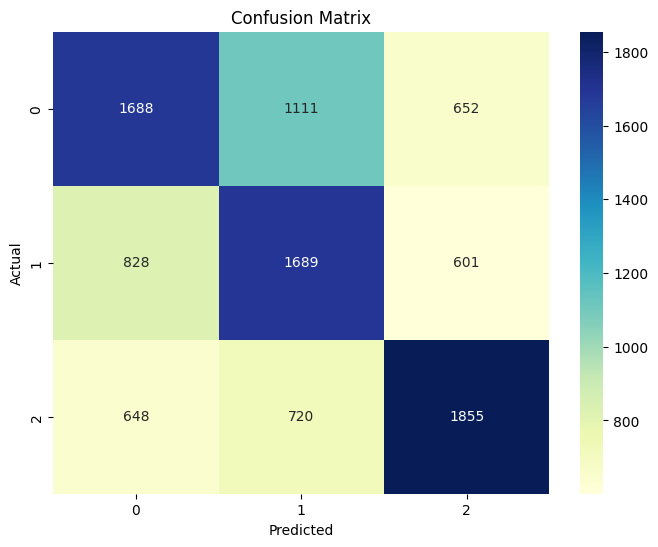

In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Recall Score : {:.2f}%".format(recall * 100))

# classification_report
class_report = classification_report(test_labels, test_preds)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()